In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

2021-10-09 22:00:56.118277: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=30
CHANNELS=3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/satellite-image-classification/data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5631 files belonging to 4 classes.


2021-10-09 22:01:14.605496: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-09 22:01:14.610205: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-09 22:01:14.646209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 22:01:14.646806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-09 22:01:14.646853: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-09 22:01:14.656743: I tensorflow/stream_executor/platform/def

In [5]:
class_names = dataset.class_names
class_names

['cloudy', 'desert', 'green_area', 'water']

In [6]:
len(dataset)

91

In [7]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

2021-10-09 22:01:29.391762: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-09 22:01:29.392765: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


(62, 256, 256, 3)
tf.Tensor(
[[[43.       60.       67.      ]
  [43.       60.       67.      ]
  [43.       60.125    66.75    ]
  ...
  [58.       77.25     74.875   ]
  [58.       77.       75.      ]
  [58.       77.       75.      ]]

 [[43.       60.       67.      ]
  [43.       60.       67.      ]
  [43.       60.125    66.75    ]
  ...
  [58.       77.25     74.875   ]
  [58.       77.       75.      ]
  [58.       77.       75.      ]]

 [[43.       60.       67.      ]
  [43.       60.       67.      ]
  [43.015625 60.140625 66.765625]
  ...
  [57.890625 77.140625 74.546875]
  [57.875    76.875    74.625   ]
  [57.875    76.875    74.625   ]]

 ...

 [[51.125    93.125    73.125   ]
  [51.125    93.125    73.125   ]
  [51.171875 93.125    73.140625]
  ...
  [41.828125 71.046875 66.828125]
  [41.625    70.875    66.625   ]
  [41.625    70.875    66.625   ]]

 [[51.       93.       73.      ]
  [51.       93.       73.      ]
  [51.       93.       73.      ]
  ...
  [42.125

ValueError: num must be 1 <= num <= 32, not 33

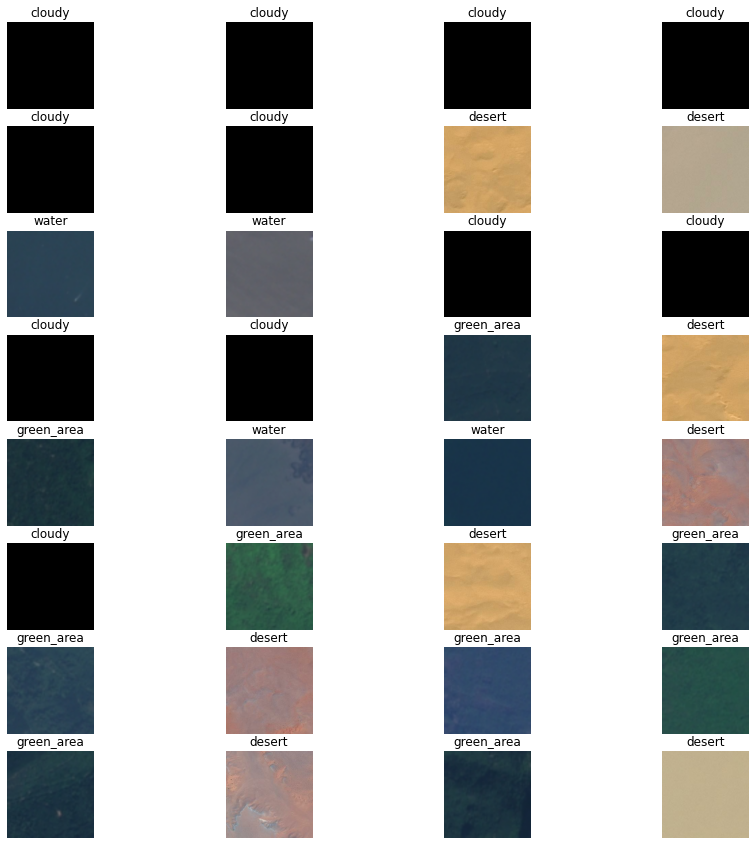

In [8]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (62, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (62, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (62, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (62, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (62, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (62, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (62, 30, 30, 64)         

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30


2021-10-09 22:03:13.877562: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-09 22:03:14.173243: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-09 22:03:23.880461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 10000
2021-10-09 22:03:24.521864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2021-10-09 22:03:24.521956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1 of 1000
2021-10-09 22:03:24.551207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2021-10-09 22:03:24.551304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1 of 1000
2021-10-09 22:03:24.551897: I tensorflow/core/ker

72/72 [==============================] - 28s 213ms/step - loss: 1.2196 - accuracy: 0.5132 - val_loss: 0.3240 - val_accuracy: 0.8172
Epoch 2/30
72/72 [==============================] - 4s 62ms/step - loss: 0.3517 - accuracy: 0.7658 - val_loss: 0.3012 - val_accuracy: 0.8315
Epoch 3/30
72/72 [==============================] - 5s 63ms/step - loss: 0.3521 - accuracy: 0.7741 - val_loss: 0.3196 - val_accuracy: 0.7437
Epoch 4/30
72/72 [==============================] - 4s 62ms/step - loss: 0.3521 - accuracy: 0.7785 - val_loss: 0.3199 - val_accuracy: 0.8082
Epoch 5/30
72/72 [==============================] - 4s 62ms/step - loss: 0.3440 - accuracy: 0.7918 - val_loss: 0.2821 - val_accuracy: 0.8889
Epoch 6/30
72/72 [==============================] - 4s 62ms/step - loss: 0.3108 - accuracy: 0.8520 - val_loss: 0.2810 - val_accuracy: 0.8961
Epoch 7/30
72/72 [==============================] - 4s 62ms/step - loss: 0.2517 - accuracy: 0.8884 - val_loss: 0.2332 - val_accuracy: 0.9050
Epoch 8/30
72/72 [====

In [18]:
model.evaluate(test_ds)

 7/10 [====================>.........] - ETA: 0s - loss: 0.0862 - accuracy: 0.9677

2021-10-09 22:06:23.386801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1 of 1000
2021-10-09 22:06:23.387025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2021-10-09 22:06:23.387239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1 of 1000
2021-10-09 22:06:23.387505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


10/10 [==============================] - 10s 26ms/step - loss: 0.1062 - accuracy: 0.9581


[0.10618778318166733, 0.9580644965171814]

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

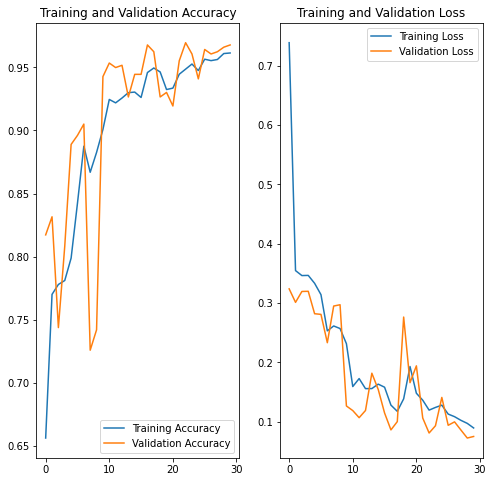

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

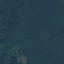

In [21]:
image_path = "../input/satellite-image-classification/data/green_area/Forest_1404.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [23]:
pred = model.predict(scaled_img)

In [24]:
output = class_names[np.argmax(pred)]

In [25]:
output

'green_area'

In [26]:
model.save("satellite_image.h5")